Short demo for 3d Flood visualization

In [109]:
# !pip install geopandas shapely pyvista numpy

Create a synthetic polygon GeoDataFrame

In [110]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
from matplotlib.colors import LinearSegmentedColormap


# Create grid extents (edges)
nx, ny = 20, 20
x = np.linspace(0, 100, nx)
y = np.linspace(0, 100, ny)

# Cell centers
grid_x = (x[:-1] + x[1:]) / 2.0
grid_y = (y[:-1] + y[1:]) / 2.0
Xc, Yc = np.meshgrid(grid_x, grid_y, indexing="ij")  # shape (nx-1, ny-1)

# 1) Terrain elevation (m): broad slope + a few hills + gentle ridges
slope = 0.03 * (Xc - Xc.mean()) + 0.015 * (Yc - Yc.mean())

hills = np.zeros_like(Xc)
for (cx, cy, h, sx, sy) in [
    (30, 30, 6.0, 18, 14),
    (70, 25, 4.5, 14, 10),
    (60, 75, 7.5, 16, 16),
]:
    hills += h * np.exp(-(((Xc - cx) ** 2) / (2 * sx ** 2) + ((Yc - cy) ** 2) / (2 * sy ** 2)))

ridges = 0.8 * np.sin(2 * np.pi * Xc / 60.0) * np.sin(2 * np.pi * Yc / 75.0)

Z0 = slope + hills + ridges  # raw terrain
# normalize to 0..12 m
Z0 = Z0 - Z0.min()
Z0 = 12.0 * Z0 / (Z0.max() + 1e-9)

# 2) Water sources: meandering rivers + compact lakes -> distance fields
def river_distance(amplitude, freq, phase, y_offset, ns=400):
    xs = np.linspace(x.min(), x.max(), ns)
    ys = y_offset + amplitude * np.sin(freq * xs + phase)
    Xf = Xc.reshape(-1, 1)
    Yf = Yc.reshape(-1, 1)
    dx = Xf - xs[None, :]
    dy = Yf - ys[None, :]
    d = np.sqrt(dx * dx + dy * dy).min(axis=1)
    return d.reshape(Xc.shape)

D1 = river_distance(8.0, 0.06, 0.0, 30.0)
D2 = river_distance(6.0, 0.05, 1.2, 70.0)

def gaussian_lake(cx, cy, sigma):
    return np.exp(-(((Xc - cx) ** 2 + (Yc - cy) ** 2) / (2 * sigma ** 2)))

lake1 = gaussian_lake(25, 25, 7)
lake2 = gaussian_lake(80, 35, 6)

S_rivers = np.maximum(np.exp(-(D1 ** 2) / (2 * 5.5 ** 2)),
                      np.exp(-(D2 ** 2) / (2 * 5.0 ** 2)))
S = np.clip(S_rivers + 0.9 * lake1 + 0.8 * lake2, 0, None)

# 3) Flood depth (m): suppressed at high elevation, stronger near sources
ne = (Z0 - Z0.min()) / (Z0.ptp() + 1e-9)  # normalized elevation
alpha = 2.0      # how strongly elevation suppresses flooding
scale = 4.0      # overall intensity
threshold = 0.6  # trims tiny puddles
F = np.clip(scale * (1.0 - ne) ** alpha * S - threshold, 0.0, None)

# 4) Polygons and GeoDataFrame (store both elev and flood)
polygons = []
for i in range(len(x) - 1):
    for j in range(len(y) - 1):
        poly = Polygon([
            (x[i], y[j]),
            (x[i + 1], y[j]),
            (x[i + 1], y[j + 1]),
            (x[i], y[j + 1]),
        ])
        polygons.append(poly)

flood_levels = F.ravel(order="C")
elev_levels = Z0.ravel(order="C")

gdf = gpd.GeoDataFrame(
    {"flood": flood_levels, "elev": elev_levels},
    geometry=polygons
)

gdf.head()

,flood,elev,geometry
0,0.00000,0.000000,"POLYGON ((0 0, 5.26316 0, 5.26316 5.26316, 0 5..."
1,0.00000,0.514481,"POLYGON ((0 5.26316, 5.26316 5.26316, 5.26316 ..."
2,0.00000,1.129680,"POLYGON ((0 10.52632, 5.26316 10.52632, 5.2631..."
3,0.00000,1.763410,"POLYGON ((0 15.78947, 5.26316 15.78947, 5.2631..."
4,0.62619,2.273699,"POLYGON ((0 21.05263, 5.26316 21.05263, 5.2631..."


Visualize in 3D with PyVista

c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


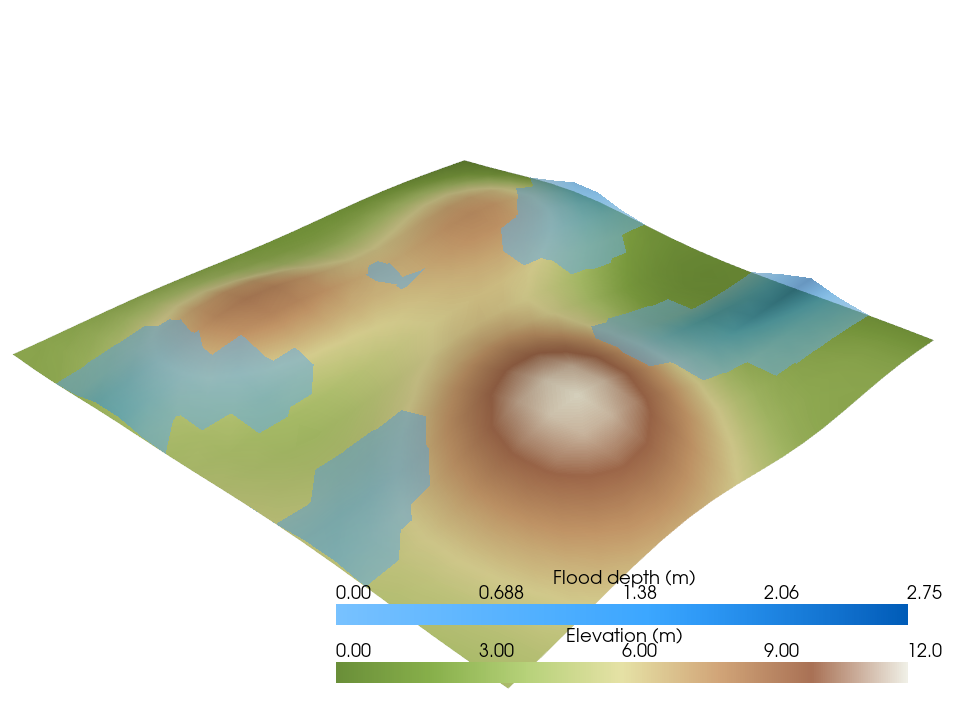

In [111]:
def plot_terrain_and_flood(
    x_edges,
    y_edges,
    elev_grid,
    flood_grid,
    camera_position=((170, 160, 110), (50, 50, 0), (0, 0, 1)),
    ticks="none",
    terrain_cmap="terrain",
    water_cmap="Blues",
    background="white",
    water_opacity=0.6,
    window_size=(960, 720),
    show=True,
):
    """
    Render terrain (elevation) and water surface (elevation + flood depth) as two surfaces.
    """
    x = np.asarray(x_edges)
    y = np.asarray(y_edges)
    Z0 = np.asarray(elev_grid)
    F = np.asarray(flood_grid)

    # centers
    grid_x = (x[:-1] + x[1:]) / 2.0
    grid_y = (y[:-1] + y[1:]) / 2.0
    Xc, Yc = np.meshgrid(grid_x, grid_y, indexing="ij")

    if Z0.shape != Xc.shape or F.shape != Xc.shape:
        raise ValueError("elev_grid and flood_grid must have shape (len(x_edges)-1, len(y_edges)-1)")

    terrain = pv.StructuredGrid(Xc, Yc, Z0)
    water = pv.StructuredGrid(Xc, Yc, Z0 + F)

    # attach scalars for coloring
    terrain["elev"] = Z0.ravel(order="F")
    water["flood"] = F.ravel(order="F")
    water = water.threshold(value=1e-9, scalars="flood")

    p = pv.Plotter(window_size=window_size)
    # terrain
    p.add_mesh(
        terrain,
        scalars="elev",
        cmap=terrain_cmap,
        smooth_shading=True,
        show_edges=False,
        scalar_bar_args={"title": "Elevation (m)"},
        opacity=1.0,
    )
    # water (semi-transparent blue, colored by depth)
    p.add_mesh(
        water,
        scalars="flood",
        cmap=water_cmap,
        smooth_shading=True,
        show_edges=False,
        scalar_bar_args={"title": "Flood depth (m)"},
        opacity=water_opacity,
        clim=(0, max(1e-9, float(F.max()))),
    )

    # axes/grid
    valid = {"inside", "outside", "both", "none"}
    if ticks not in valid:
        raise ValueError(f"ticks must be one of {valid}")
    if ticks == "none":
        try:
            p.hide_axes()
        except Exception:
            pass
    else:
        p.show_grid(xlabel="", ylabel="", zlabel="", ticks=ticks, color="lightgray")

    p.set_background(background)
    p.camera_position = camera_position

    if show:
        p.show()
    return p


elev_colors = [
    "#6a8f39",  # dark green
    "#88b04b",  # green
    "#b7d27a",  # light green/yellow
    "#e6e2a6",  # sand
    "#d2a679",  # light brown
    "#a97155",  # brown
    "#f0efe6",  # off-white peaks
]


flood_colors = [
    '#78c2ff',  # light sky blue
    '#6ebdff',
    '#64b9ff',
    '#5ab4ff',
    '#50b0ff',
    '#46abff',
    '#3ca7ff',
    '#2f9af7',
    '#238be9',
    '#187cd9',
    '#0e6cc9',
    '#005cb8'   # darkest blue
]

elev_cmap = LinearSegmentedColormap.from_list("elev_no_blue", elev_colors, N=256)
flood_cmap = LinearSegmentedColormap.from_list("flood_blue_cont", flood_colors, N=256)


camera = ((170, 160, 110), (50, 50, 0), (0, 0, 1))
plot_terrain_and_flood(x, y, Z0, F, camera_position=camera, ticks="none", water_cmap=flood_cmap, terrain_cmap=elev_cmap)

c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\plotting\renderer.py:1972: PyVistaDeprecationWarning: `xlabel` is deprecated. Use `xtitle` instead.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\plotting\renderer.py:1978: PyVistaDeprecationWarning: `ylabel` is deprecated. Use `ytitle` instead.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\plotting\renderer.py:1984: PyVistaDeprecationWarning: `zlabel` is deprecated. Use `ztitle` instead.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(
ERROR:root:Text is not set!
ERROR:root:Algorithm vtkVectorText (00000207464D72E0) returned failure for request: vtkInformation (00000207469BA060)
ERROR:root:Text is not set!
ERROR:root:Algorithm 

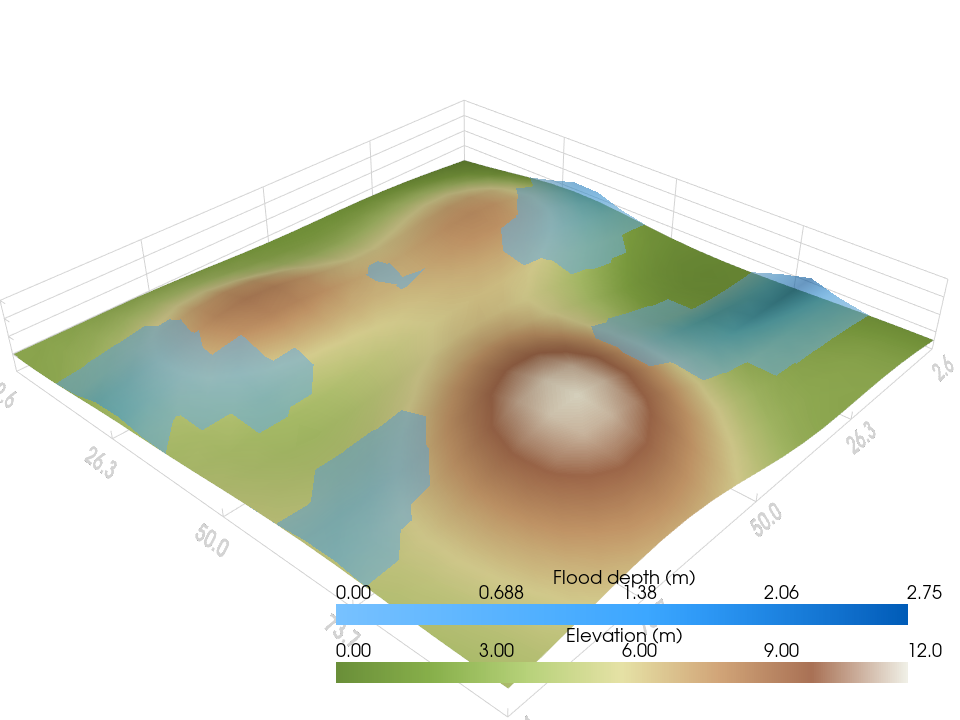

In [112]:
camera = ((170, 160, 110), (50, 50, 0), (0, 0, 1))
plot_terrain_and_flood(x, y, Z0, F, camera_position=camera, ticks="inside",  water_cmap=flood_cmap, terrain_cmap=elev_cmap)

c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\plotting\renderer.py:1972: PyVistaDeprecationWarning: `xlabel` is deprecated. Use `xtitle` instead.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\plotting\renderer.py:1978: PyVistaDeprecationWarning: `ylabel` is deprecated. Use `ytitle` instead.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\plotting\renderer.py:1984: PyVistaDeprecationWarning: `zlabel` is deprecated. Use `ztitle` instead.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(
ERROR:root:Text is not set!
ERROR:root:Algorithm vtkVectorText (00000207464DDB00) returned failure for request: vtkInformation (0000020760160C70)
ERROR:root:Text is not set!
ERROR:root:Algorithm 

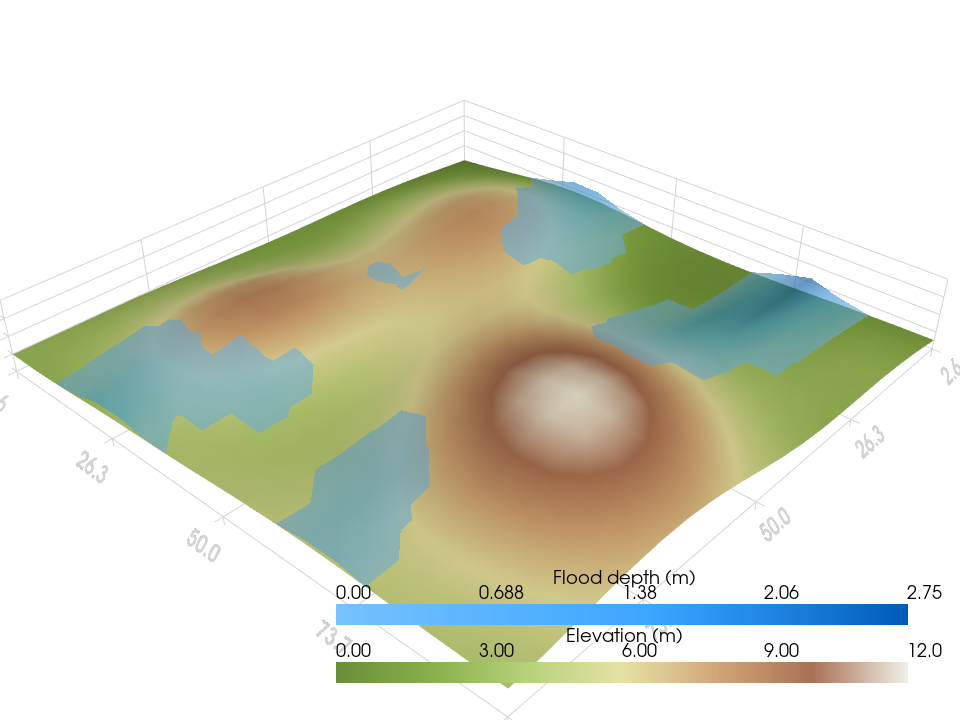

In [113]:
camera = ((170, 160, 110), (50, 50, 0), (0, 0, 1))
plot_terrain_and_flood(x, y, Z0, F, camera_position=camera, ticks="outside",  water_cmap=flood_cmap, terrain_cmap=elev_cmap)

c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\plotting\renderer.py:1972: PyVistaDeprecationWarning: `xlabel` is deprecated. Use `xtitle` instead.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\plotting\renderer.py:1978: PyVistaDeprecationWarning: `ylabel` is deprecated. Use `ytitle` instead.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\plotting\renderer.py:1984: PyVistaDeprecationWarning: `zlabel` is deprecated. Use `ztitle` instead.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(
ERROR:root:Text is not set!
ERROR:root:Algorithm vtkVectorText (00000207464E2C60) returned failure for request: vtkInformation (000002076015C520)
ERROR:root:Text is not set!
ERROR:root:Algorithm 

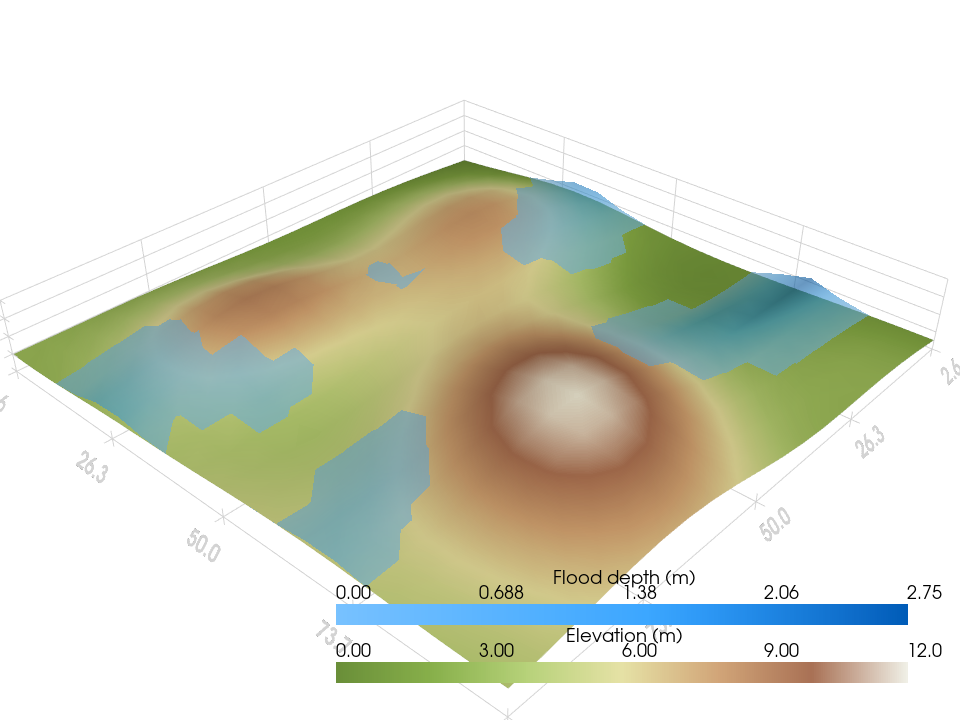

In [114]:
camera = ((170, 160, 110), (50, 50, 0), (0, 0, 1))
plot_terrain_and_flood(x, y, Z0, F, camera_position=camera, ticks="both",  water_cmap=flood_cmap, terrain_cmap=elev_cmap)

c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


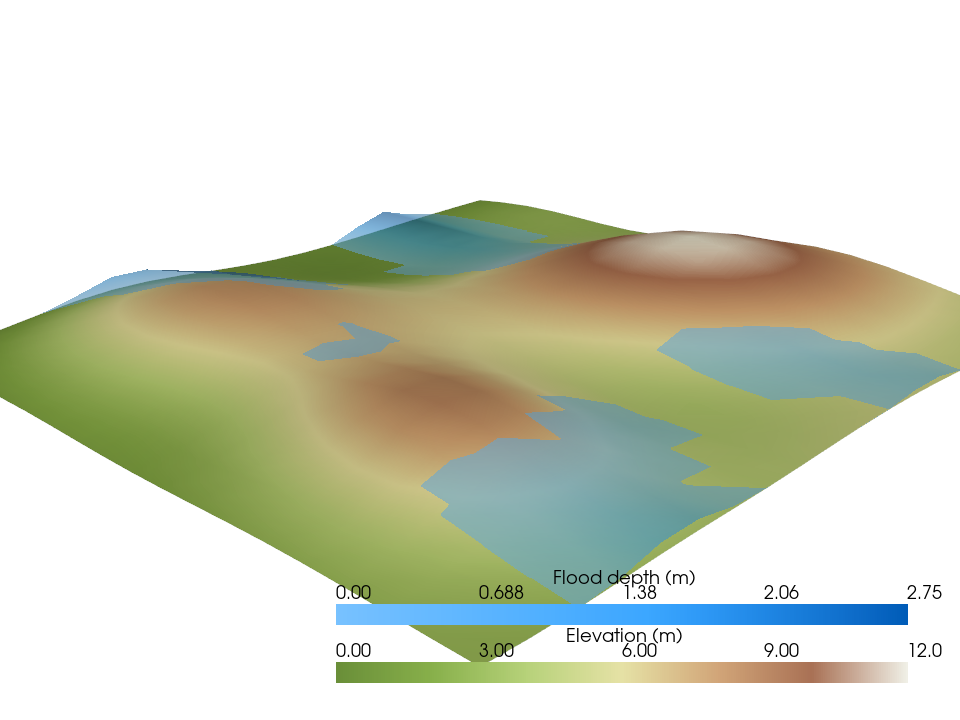

In [117]:
camera = ((155.45, -55.45, 60), (50, 50, 0), (0, 0, 1))
plot_terrain_and_flood(x, y, Z0, F, camera_position=camera, ticks="none",  water_cmap=flood_cmap, terrain_cmap=elev_cmap)

2D map for context

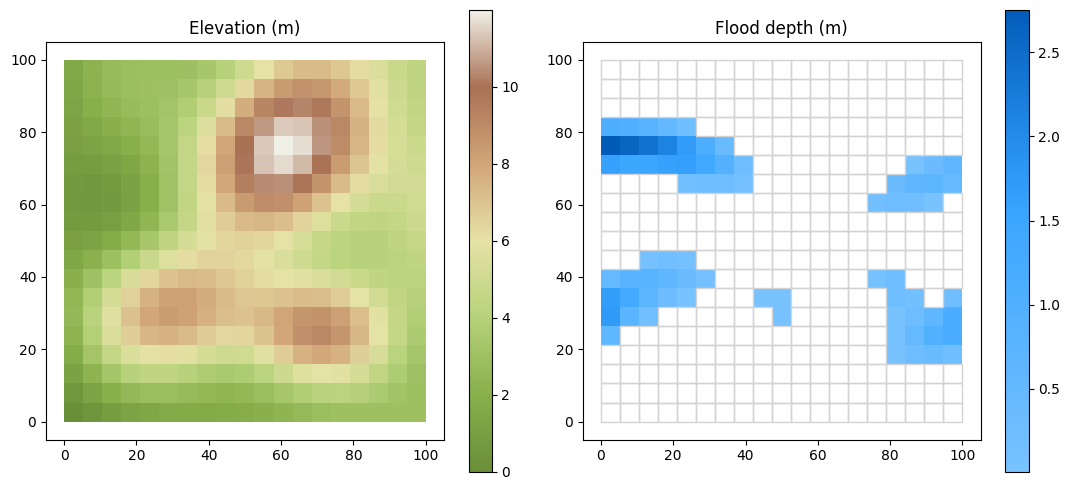

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

gdf.plot(column="elev", cmap=elev_cmap, legend=True, ax=axes[0])
axes[0].set_title("Elevation (m)")

# Do not color polygons where flood == 0
gdf["flood_plot"] = gdf["flood"].mask(gdf["flood"].le(0))

gdf.plot(
    column="flood_plot",
    cmap=flood_cmap,
    legend=True,
    ax=axes[1],
    missing_kwds={"color": "none", "edgecolor": "lightgray", "label": "No flood"},
)
axes[1].set_title("Flood depth (m)")
plt.tight_layout()
plt.show()